# Exploratory Data Analysis (EDA) for Blood Donation Datasets
This notebook analyzes two datasets:
- `donations_facility.csv`
- `donations_state.csv`

It covers data loading, cleaning, verification, descriptive statistics, time series analysis, and more.

**Author:** (Your Name)  
**Date:** June 11, 2025

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## 1. Load Data
Read the facility and state donation datasets.

In [3]:
# Load the datasets
facility_df = pd.read_csv('donations_facility.csv')
state_df = pd.read_csv('donations_state.csv')

# Exclude rows where state is 'Malaysia' (case-insensitive) in state_df
# EXPLANATION: The 'Malaysia' row in donations_state.csv represents the national total (sum of all states).
# Including it would double-count the national total in any state-level analysis or comparison.
# We exclude it to ensure only individual state data is used for accurate analysis.
if 'state' in state_df.columns:
    state_df = state_df[~state_df['state'].str.lower().eq('malaysia')].copy()

## 2. Initial Inspection
Preview the structure and first few rows of each dataset.

In [4]:
print("--- Facility Data Overview ---")
print(facility_df.info())
print(facility_df.head())

print("\n--- State Data Overview ---")
print(state_df.info())
print(state_df.head())

--- Facility Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198828 entries, 0 to 198827
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   date                     198828 non-null  object
 1   hospital                 156222 non-null  object
 2   daily                    198828 non-null  int64 
 3   blood_a                  198828 non-null  int64 
 4   blood_b                  198828 non-null  int64 
 5   blood_o                  198828 non-null  int64 
 6   blood_ab                 198828 non-null  int64 
 7   location_centre          198828 non-null  int64 
 8   location_mobile          198828 non-null  int64 
 9   type_wholeblood          198828 non-null  int64 
 10  type_apheresis_platelet  198828 non-null  int64 
 11  type_apheresis_plasma    198828 non-null  int64 
 12  type_other               198828 non-null  int64 
 13  social_civilian          198828 non-null  i

## 3. Data Cleaning
Convert date columns, check for missing values, and fill missing names.

In [5]:
# Convert 'date' to datetime
facility_df['date'] = pd.to_datetime(facility_df['date'], errors='coerce')
state_df['date'] = pd.to_datetime(state_df['date'], errors='coerce')

# Check for missing values
print("Facility missing values:\n", facility_df.isnull().sum())
print("State missing values:\n", state_df.isnull().sum())

# Fill missing hospital/state names with 'Unknown'
facility_df['hospital'] = facility_df['hospital'].fillna('Unknown')
if 'state' in state_df.columns:
    state_df['state'] = state_df['state'].fillna('Unknown')

Facility missing values:
 date                           0
hospital                   42606
daily                          0
blood_a                        0
blood_b                        0
blood_o                        0
blood_ab                       0
location_centre                0
location_mobile                0
type_wholeblood                0
type_apheresis_platelet        0
type_apheresis_plasma          0
type_other                     0
social_civilian                0
social_student                 0
social_policearmy              0
donations_new                  0
donations_regular              0
donations_irregular            0
dtype: int64
State missing values:
 date                       0
state                      0
daily                      0
blood_a                    0
blood_b                    0
blood_o                    0
blood_ab                   0
location_centre            0
location_mobile            0
type_wholeblood            0
type_apheresis_platel

## 4. Verification: Compare Daily Totals by Date Between Facility and State Files
**Explanation:**  
The 'daily' column in both files represents the total number of donations for each date. In the facility file, this is the sum across all hospitals for a given date. In the state file, this is the reported total for the entire country (or state) for that date. To verify data consistency, we sum the 'daily' values by date in the facility file and compare them to the corresponding 'daily' value in the state file. Any difference may indicate missing data, reporting errors, or aggregation issues. We print summary statistics, count mismatches, and show a few examples. A plot visualizes the difference over time.


--- Verification of Daily Totals (Facility vs State) ---
This section checks if the sum of daily donations from all facilities matches the reported total in the state file for each date. Ideally, the difference should be zero for all dates. Any nonzero difference may indicate data inconsistencies or missing records.
       facility_total  state_total   difference
count     7101.000000  7101.000000  7101.000000
mean      1282.444444  1281.229827     1.214618
std        647.901512   646.676834     8.492938
min          0.000000     0.000000     0.000000
25%        835.000000   834.000000     0.000000
50%       1173.000000  1172.000000     0.000000
75%       1606.000000  1604.000000     0.000000
max       5543.000000  5543.000000   143.000000

Number of mismatched days: 278
Sample of mismatched days (first 20):
            facility_total  state_total  difference
date                                               
2024-06-13            1505         1504           1
2024-06-14            1

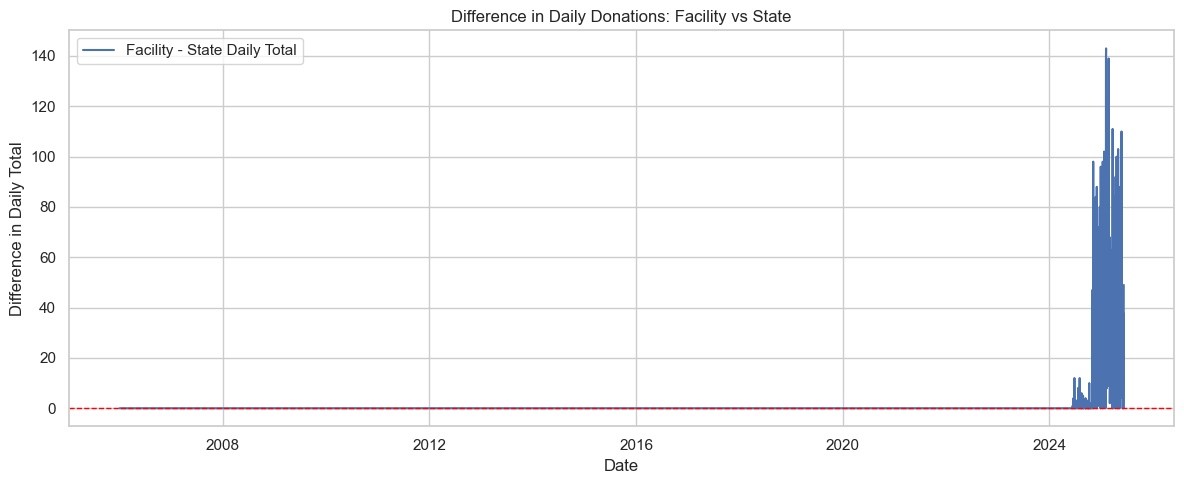

In [6]:
# Sum daily donations by date for both datasets
facility_daily_sum = facility_df.groupby('date')['daily'].sum().sort_index()
state_daily_sum = state_df.groupby('date')['daily'].sum().sort_index()

# Merge for comparison
verification_df = pd.DataFrame({
    'facility_total': facility_daily_sum,
    'state_total': state_daily_sum
})
verification_df['difference'] = verification_df['facility_total'] - verification_df['state_total']

# Show summary statistics and mismatches
print("\n--- Verification of Daily Totals (Facility vs State) ---")
print("This section checks if the sum of daily donations from all facilities matches the reported total in the state file for each date. Ideally, the difference should be zero for all dates. Any nonzero difference may indicate data inconsistencies or missing records.")
print(verification_df.describe())

# Show dates where the difference is not zero
mismatches = verification_df[verification_df['difference'] != 0]
print(f"\nNumber of mismatched days: {len(mismatches)}")
if not mismatches.empty:
    print("Sample of mismatched days (first 20):")
    print(mismatches.head(20))
else:
    print("All daily totals match between facility and state files.")

# Visualize the difference over time
plt.figure(figsize=(12,5))
plt.plot(verification_df.index, verification_df['difference'], label='Facility - State Daily Total')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Difference in Daily Donations: Facility vs State')
plt.xlabel('Date')
plt.ylabel('Difference in Daily Total')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Descriptive Statistics
Summary statistics for both datasets.

In [7]:
print("--- Facility Data Description ---")
print(facility_df.describe())

print("\n--- State Data Description ---")
print(state_df.describe())

--- Facility Data Description ---
                      date          daily        blood_a        blood_b  \
count               198828  198828.000000  198828.000000  198828.000000   
mean   2015-09-21 00:00:00      45.801587      11.371693      12.464532   
min    2006-01-01 00:00:00       0.000000       0.000000       0.000000   
25%    2010-11-11 00:00:00       0.000000       0.000000       0.000000   
50%    2015-09-21 00:00:00       7.000000       1.000000       2.000000   
75%    2020-07-31 00:00:00      49.000000      12.000000      13.000000   
max    2025-06-10 00:00:00    2667.000000     590.000000     842.000000   
std                    NaN     108.546967      27.422126      29.657846   

             blood_o       blood_ab  location_centre  location_mobile  \
count  198828.000000  198828.000000    198828.000000    198828.000000   
mean       19.135539       2.828570        23.399365        22.402222   
min         0.000000       0.000000         0.000000         0.000000  

## 6. Time Series Analysis: Yearly Donations
Visualize the total yearly donations for both datasets.

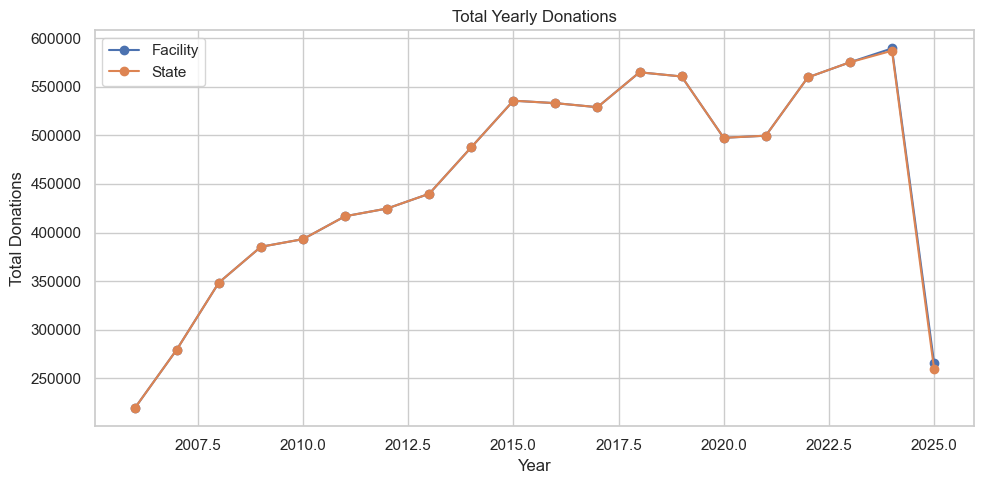

In [8]:
# Make sure all previous cells have been run so that facility_df and state_df are defined

# Group by year and sum donations
facility_yearly = facility_df.groupby(facility_df['date'].dt.year)['daily'].sum()
state_yearly = state_df.groupby(state_df['date'].dt.year)['daily'].sum()

plt.figure(figsize=(10,5))
facility_yearly.plot(label='Facility', marker='o')
state_yearly.plot(label='State', marker='o')
plt.title('Total Yearly Donations')
plt.xlabel('Year')
plt.ylabel('Total Donations')
plt.legend()
plt.tight_layout()
plt.show()

### Yearly Donation Trends by Individual Facility
Below, we show the yearly donation trends for each hospital/facility. This helps identify which facilities are growing, declining, or stable over time.

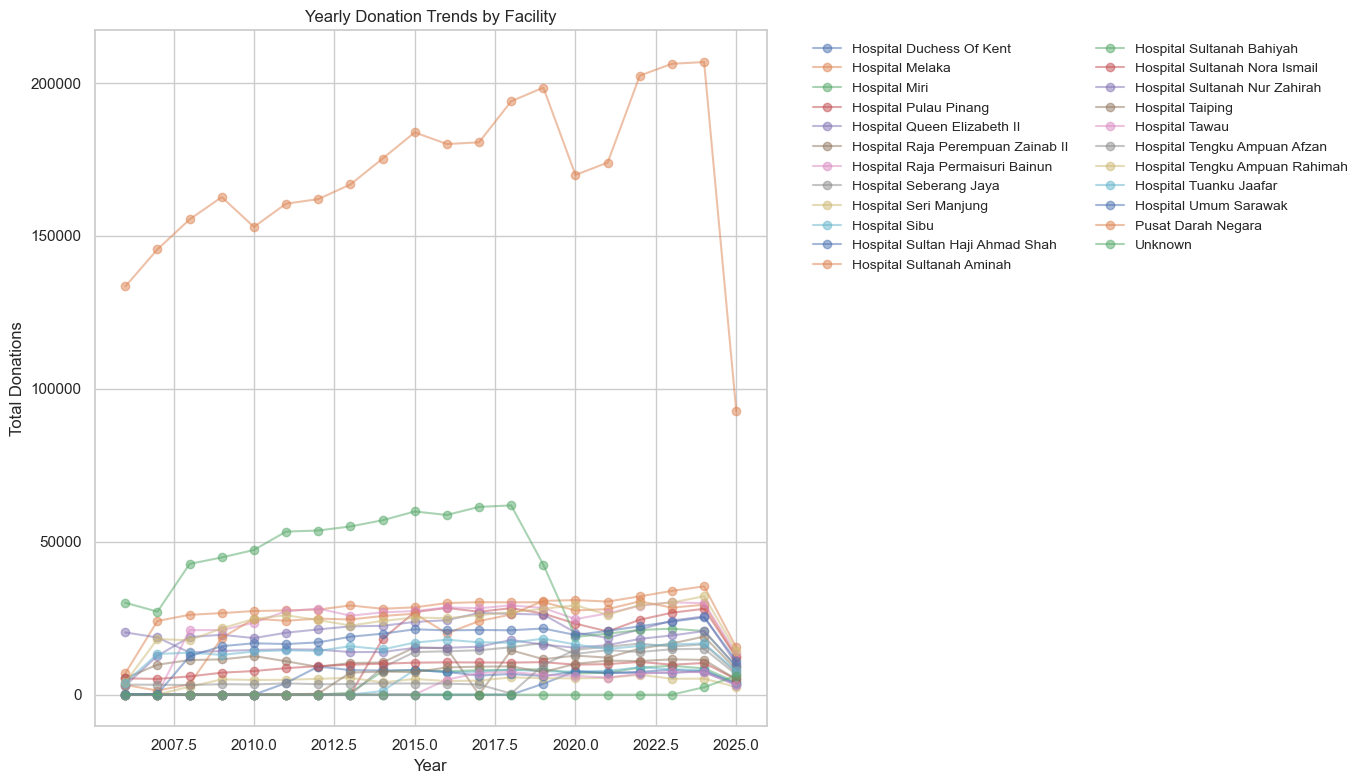

In [9]:
# Pivot table: rows=year, columns=hospital, values=total donations
facility_yearly_pivot = facility_df.pivot_table(index=facility_df['date'].dt.year, columns='hospital', values='daily', aggfunc='sum')
plt.figure(figsize=(14,8))
for col in facility_yearly_pivot.columns:
    plt.plot(facility_yearly_pivot.index, facility_yearly_pivot[col], marker='o', label=col, alpha=0.5)
plt.title('Yearly Donation Trends by Facility')
plt.xlabel('Year')
plt.ylabel('Total Donations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2, frameon=False)
plt.tight_layout()
plt.show()

### Yearly Donation Trends by Individual State
Below, we show the yearly donation trends for each state. This helps identify which states are growing, declining, or stable over time.

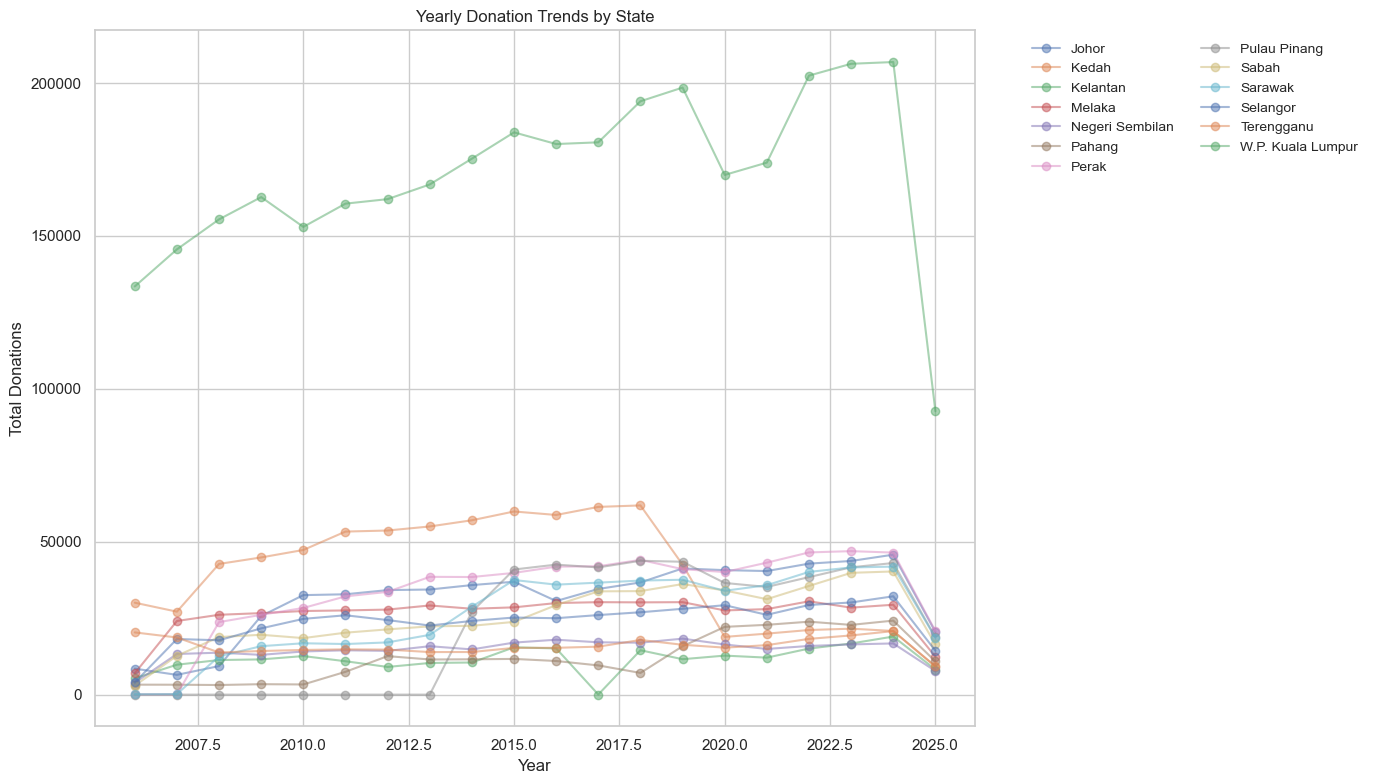

In [10]:
# Pivot table: rows=year, columns=state, values=total donations
state_yearly_pivot = state_df.pivot_table(index=state_df['date'].dt.year, columns='state', values='daily', aggfunc='sum')
plt.figure(figsize=(14,8))
for col in state_yearly_pivot.columns:
    plt.plot(state_yearly_pivot.index, state_yearly_pivot[col], marker='o', label=col, alpha=0.5)
plt.title('Yearly Donation Trends by State')
plt.xlabel('Year')
plt.ylabel('Total Donations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2, frameon=False)
plt.tight_layout()
plt.show()

## 7. Time Series Analysis: Total Donations Over Time
Visualize the total daily donations over time for both datasets.

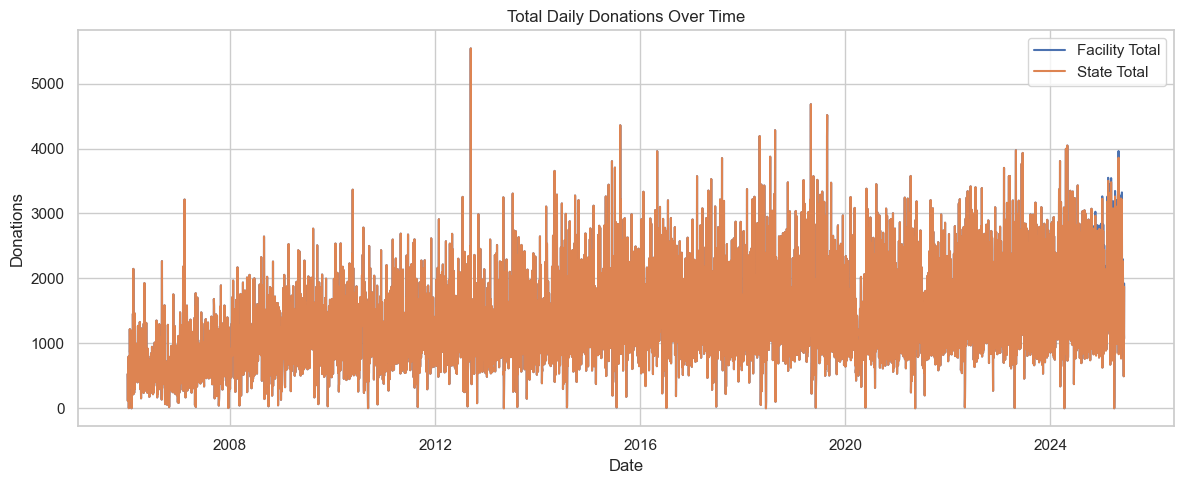

In [11]:
plt.figure(figsize=(12,5))
facility_daily = facility_df.groupby('date')['daily'].sum()
state_daily = state_df.groupby('date')['daily'].sum()
plt.plot(facility_daily.index, facility_daily.values, label='Facility Total')
plt.plot(state_daily.index, state_daily.values, label='State Total')
plt.title('Total Daily Donations Over Time')
plt.xlabel('Date')
plt.ylabel('Donations')
plt.legend()
plt.tight_layout()
plt.show()

## 8. Analysis by Hospital/Facility
Hospitals by total donations.

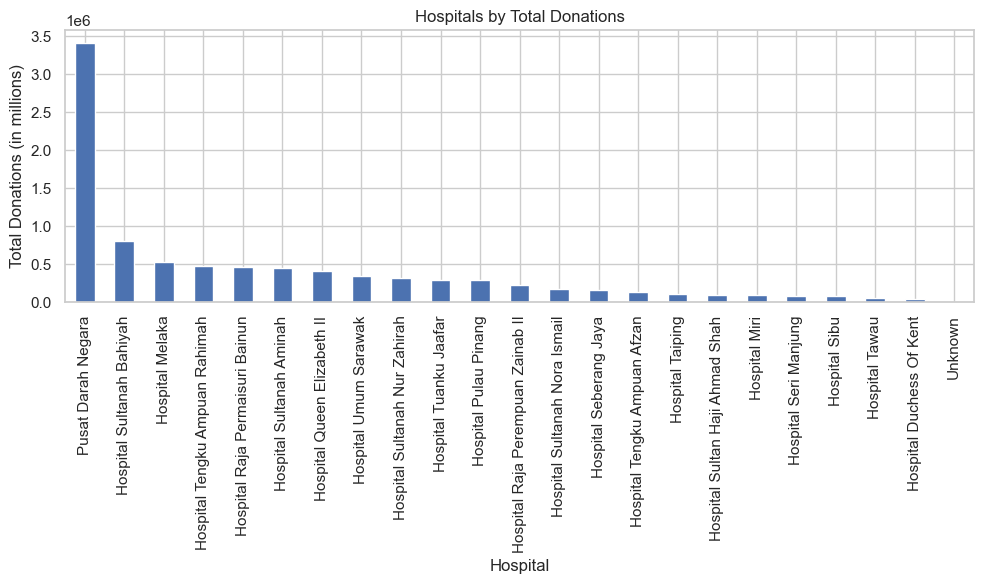

In [24]:
facility_totals = facility_df.groupby('hospital')['daily'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
facility_totals.head(23).plot(kind='bar')
plt.title('Hospitals by Total Donations')
plt.ylabel('Total Donations (in millions)')
plt.xlabel('Hospital')
plt.tight_layout()
plt.show()

## 9. Analysis by State
Total donations by state (if available).

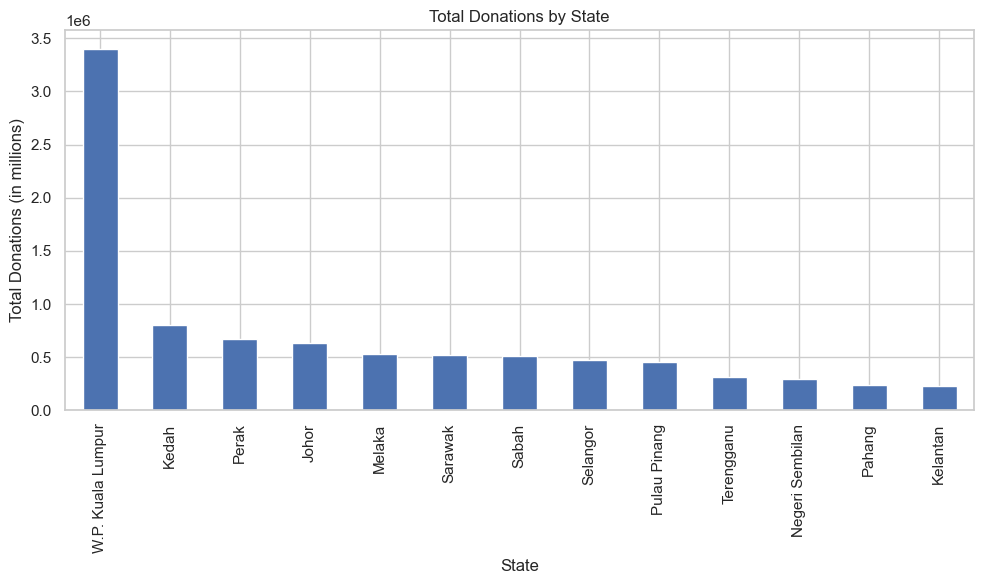

In [26]:
if 'state' in state_df.columns:
    state_totals = state_df.groupby('state')['daily'].sum().sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    state_totals.plot(kind='bar')
    plt.title('Total Donations by State')
    plt.ylabel('Total Donations (in millions)')
    plt.xlabel('State')
    plt.tight_layout()
    plt.show()

## 10. Blood Type Distribution
Compare the distribution of blood types between the two datasets.

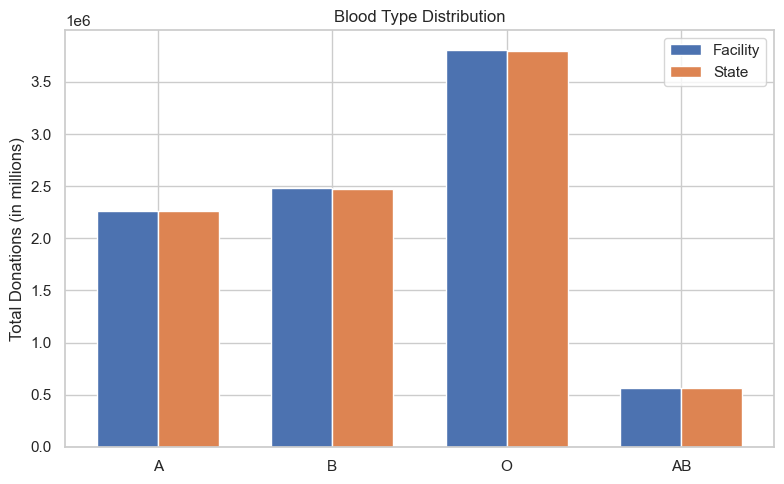

In [27]:
blood_types = ['blood_a', 'blood_b', 'blood_o', 'blood_ab']
plt.figure(figsize=(8,5))
facility_blood = facility_df[blood_types].sum()
state_blood = state_df[blood_types].sum()
width = 0.35
x = np.arange(len(blood_types))
plt.bar(x - width/2, facility_blood, width, label='Facility')
plt.bar(x + width/2, state_blood, width, label='State')
plt.xticks(x, ['A', 'B', 'O', 'AB'])
plt.ylabel('Total Donations (in millions)')
plt.title('Blood Type Distribution')
plt.legend()
plt.tight_layout()
plt.show()

## 11. Donation Type Analysis
Distribution of donation types (whole blood, apheresis platelet, apheresis plasma, other).

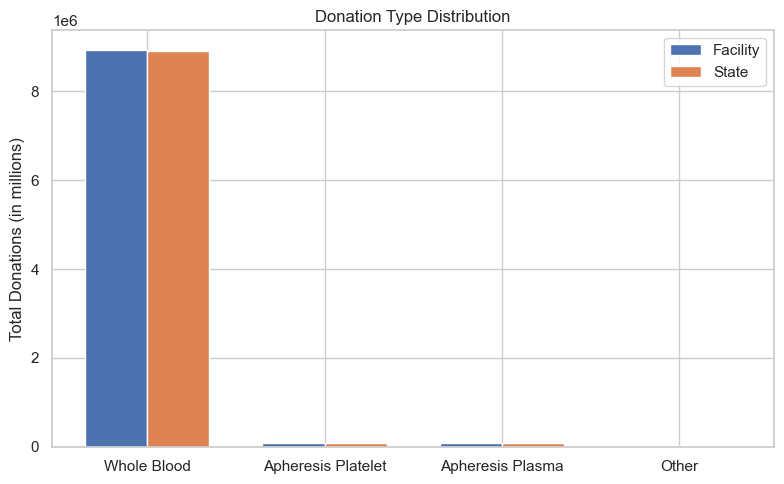

In [28]:
donation_types = ['type_wholeblood', 'type_apheresis_platelet', 'type_apheresis_plasma', 'type_other']
plt.figure(figsize=(8,5))
facility_types = facility_df[donation_types].sum()
state_types = state_df[donation_types].sum()
plt.bar(x - width/2, facility_types, width, label='Facility')
plt.bar(x + width/2, state_types, width, label='State')
plt.xticks(x, ['Whole Blood', 'Apheresis Platelet', 'Apheresis Plasma', 'Other'])
plt.ylabel('Total Donations (in millions)')
plt.title('Donation Type Distribution')
plt.legend()
plt.tight_layout()
plt.show()

## 12. Social Group Analysis
Distribution of donations by social group (civilian, student, police/army).

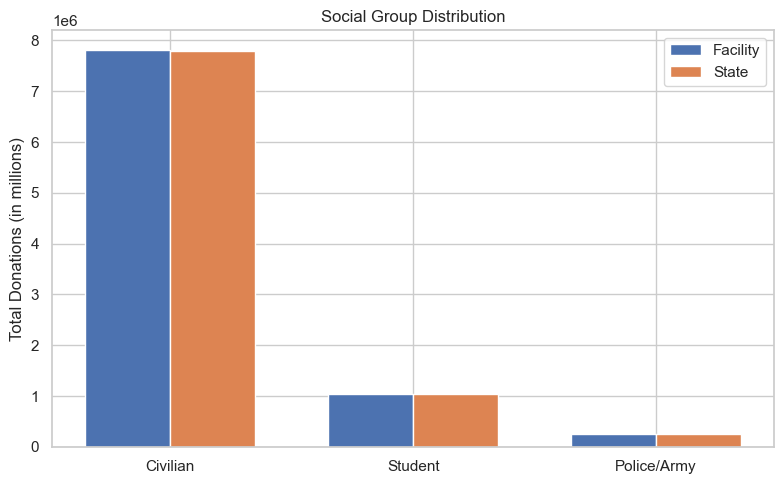

In [29]:
social_groups = ['social_civilian', 'social_student', 'social_policearmy']
plt.figure(figsize=(8,5))
facility_social = facility_df[social_groups].sum()
state_social = state_df[social_groups].sum()
x_social = np.arange(len(social_groups))
plt.bar(x_social - width/2, facility_social, width, label='Facility')
plt.bar(x_social + width/2, state_social, width, label='State')
plt.xticks(x_social, ['Civilian', 'Student', 'Police/Army'])
plt.ylabel('Total Donations (in millions)')
plt.title('Social Group Distribution')
plt.legend()
plt.tight_layout()
plt.show()

## 13. Donor Type Analysis
Distribution of new, regular, and irregular donors.

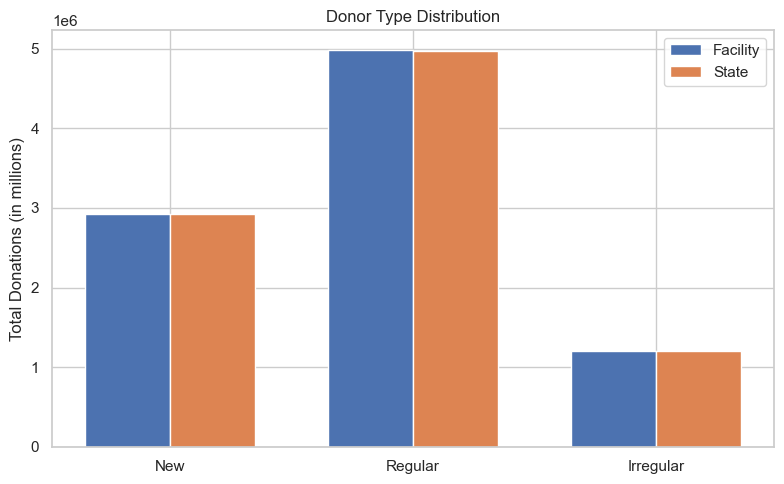

In [30]:
donor_types = ['donations_new', 'donations_regular', 'donations_irregular']
plt.figure(figsize=(8,5))
facility_donors = facility_df[donor_types].sum()
state_donors = state_df[donor_types].sum()
x_donor = np.arange(len(donor_types))
plt.bar(x_donor - width/2, facility_donors, width, label='Facility')
plt.bar(x_donor + width/2, state_donors, width, label='State')
plt.xticks(x_donor, ['New', 'Regular', 'Irregular'])
plt.ylabel('Total Donations (in millions)')
plt.title('Donor Type Distribution')
plt.legend()
plt.tight_layout()
plt.show()

## 14. Correlation Analysis
Correlation heatmaps for numeric columns in both datasets.

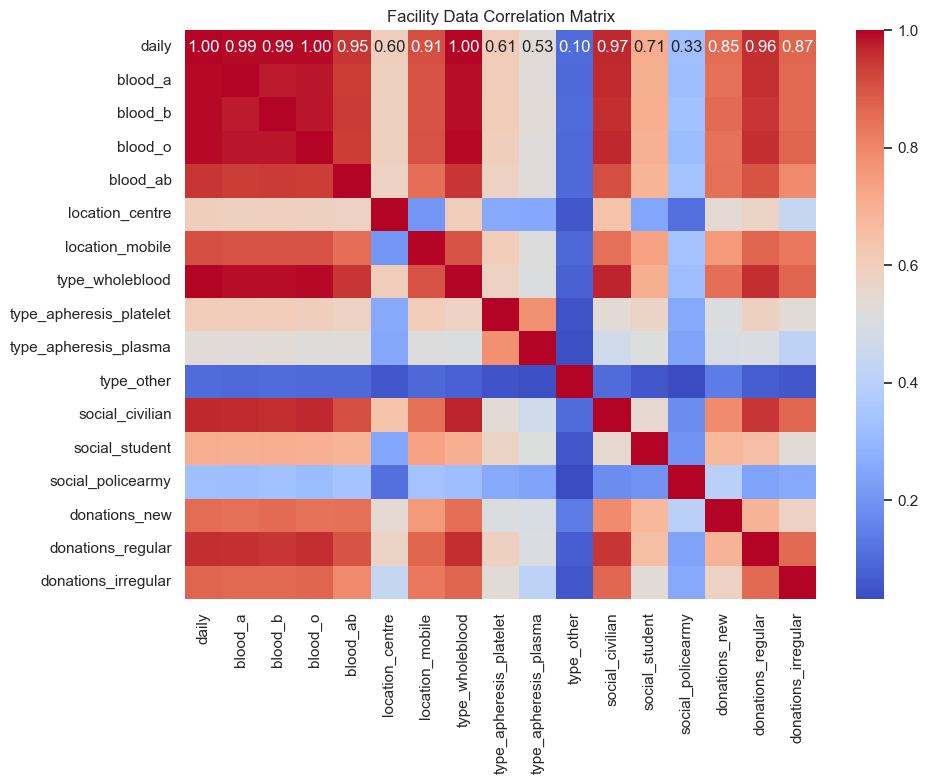

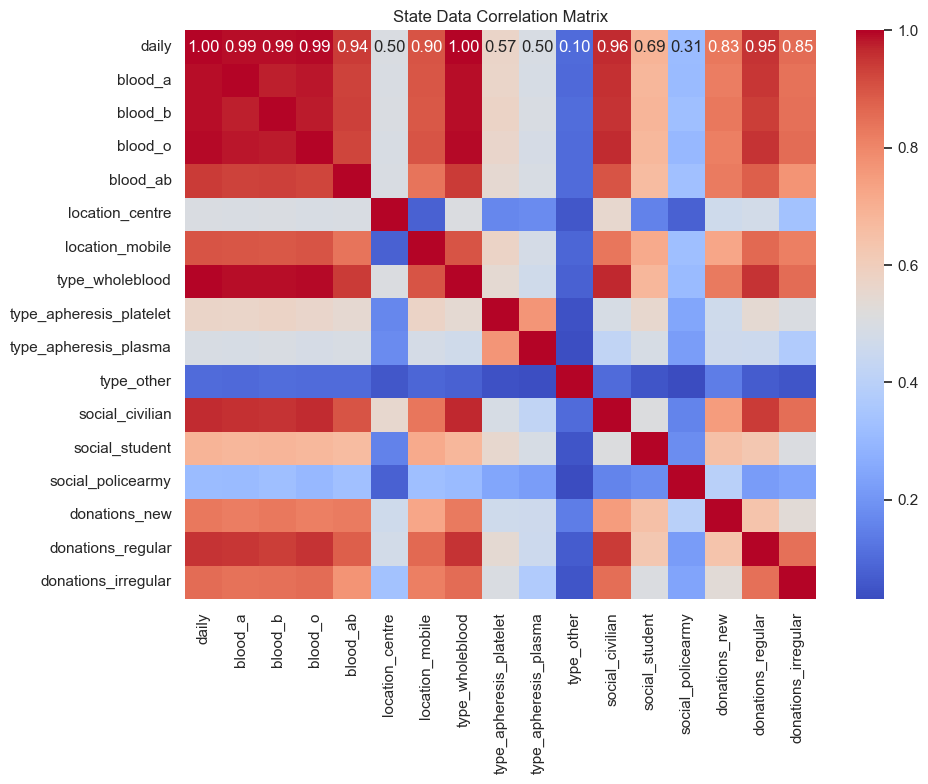

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(facility_df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Facility Data Correlation Matrix')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(state_df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('State Data Correlation Matrix')
plt.tight_layout()
plt.show()

## 15. Seasonality/Monthly Trends
Monthly trend of total donations for both datasets.

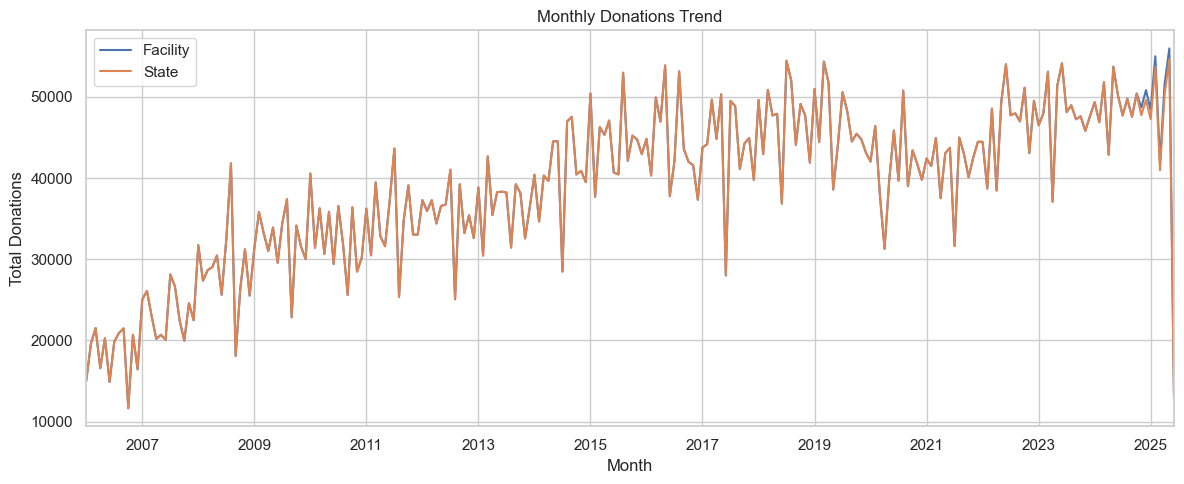

In [19]:
facility_monthly = facility_df.groupby(facility_df['date'].dt.to_period('M'))['daily'].sum()
state_monthly = state_df.groupby(state_df['date'].dt.to_period('M'))['daily'].sum()
plt.figure(figsize=(12,5))
facility_monthly.plot(label='Facility')
state_monthly.plot(label='State')
plt.title('Monthly Donations Trend')
plt.xlabel('Month')
plt.ylabel('Total Donations')
plt.legend()
plt.tight_layout()
plt.show()

## 16. Hospital Grouping by Daily Donation: Quadrant Analysis
We group hospitals by their average and variability (standard deviation) of daily donations. This helps identify:
- Facilities with consistently high donations (potential donors to others)
- Facilities with consistently low donations (potential recipients)
- Facilities with high variability (unstable supply)
- Facilities with low variability (stable supply)

We use a quadrant approach:
- Q1: High mean, high std (large, but unstable donors)
- Q2: High mean, low std (large, stable donors)
- Q3: Low mean, high std (small, unstable donors)
- Q4: Low mean, low std (small, stable donors)

This analysis helps target support and redistribution strategies.

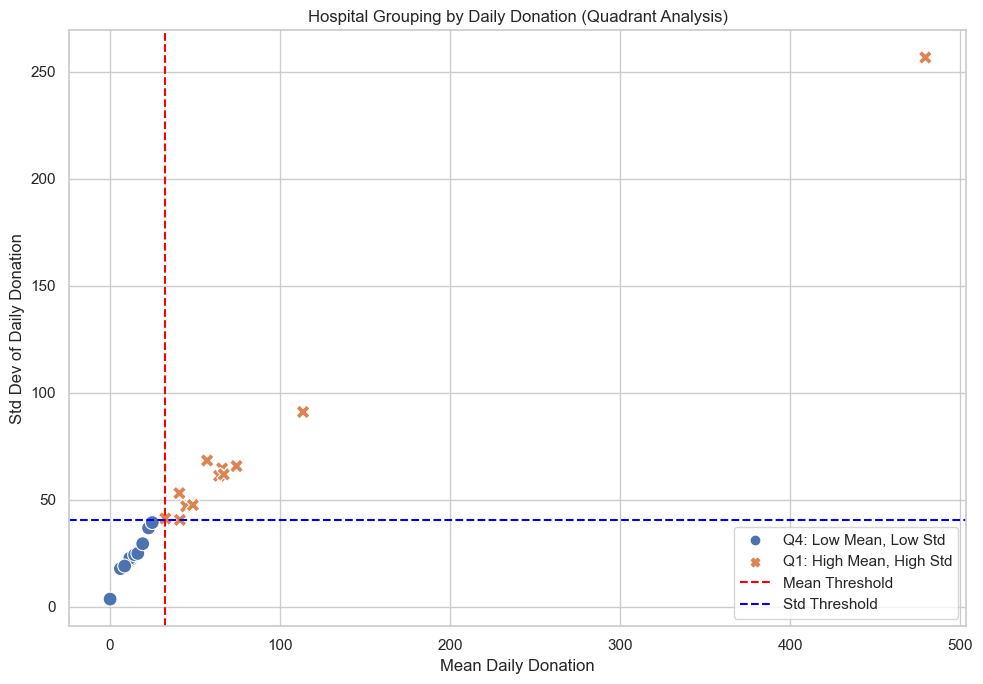


Sample hospitals in Q1: High Mean, High Std:
                                        mean        std  count  \
hospital                                                         
Hospital Melaka                    74.508942  65.672114   7101   
Hospital Pulau Pinang              40.953809  52.994343   7101   
Hospital Queen Elizabeth II        57.219687  68.270825   7101   
Hospital Raja Perempuan Zainab II  32.658921  41.169673   7101   
Hospital Raja Permaisuri Bainun    66.069849  64.576926   7101   

                                                  quadrant  
hospital                                                    
Hospital Melaka                    Q1: High Mean, High Std  
Hospital Pulau Pinang              Q1: High Mean, High Std  
Hospital Queen Elizabeth II        Q1: High Mean, High Std  
Hospital Raja Perempuan Zainab II  Q1: High Mean, High Std  
Hospital Raja Permaisuri Bainun    Q1: High Mean, High Std  

Sample hospitals in Q2: High Mean, Low Std:
Empty DataFrame
Col

In [20]:
# Calculate mean and std of daily donations for each hospital
hospital_stats = facility_df.groupby('hospital')['daily'].agg(['mean', 'std', 'count'])

# Only consider hospitals with enough data points (e.g., >30 days)
hospital_stats = hospital_stats[hospital_stats['count'] > 30]

# Calculate thresholds (median split)
mean_thresh = hospital_stats['mean'].median()
std_thresh = hospital_stats['std'].median()

# Assign quadrants
conditions = [
    (hospital_stats['mean'] >= mean_thresh) & (hospital_stats['std'] >= std_thresh),  # Q1
    (hospital_stats['mean'] >= mean_thresh) & (hospital_stats['std'] < std_thresh),   # Q2
    (hospital_stats['mean'] < mean_thresh) & (hospital_stats['std'] >= std_thresh),   # Q3
    (hospital_stats['mean'] < mean_thresh) & (hospital_stats['std'] < std_thresh)     # Q4
]
choices = ['Q1: High Mean, High Std', 'Q2: High Mean, Low Std', 'Q3: Low Mean, High Std', 'Q4: Low Mean, Low Std']
hospital_stats['quadrant'] = np.select(conditions, choices)

# Plot
plt.figure(figsize=(10,7))
sns.scatterplot(data=hospital_stats, x='mean', y='std', hue='quadrant', style='quadrant', s=100)
plt.axvline(mean_thresh, color='red', linestyle='--', label='Mean Threshold')
plt.axhline(std_thresh, color='blue', linestyle='--', label='Std Threshold')
plt.title('Hospital Grouping by Daily Donation (Quadrant Analysis)')
plt.xlabel('Mean Daily Donation')
plt.ylabel('Std Dev of Daily Donation')
plt.legend()
plt.tight_layout()
plt.show()

# Show sample hospitals from each quadrant
for q in choices:
    print(f"\nSample hospitals in {q}:")
    print(hospital_stats[hospital_stats['quadrant'] == q].head(5))

**Interpretation & Suggestions:**
- Q1 (High Mean, High Std): Large, but unstable donors. Monitor for supply swings; may help others but need stabilization.
- Q2 (High Mean, Low Std): Large, stable donors. Ideal for supporting low-donation facilities.
- Q3 (Low Mean, High Std): Small, unstable donors. Need support and stabilization.
- Q4 (Low Mean, Low Std): Small, stable donors. May need support, but predictable.

**Action:**
- Facilities in Q3 and Q4 may need more blood supply or support.
- Facilities in Q2 are best positioned to donate to those in Q3/Q4.
- Q1 facilities can help, but their instability should be addressed first.

## 17. List of Hospitals in Each Quadrant and Recommendations
Below are all hospitals grouped by their quadrant. Use this to identify which facilities need support and which can help others.

In [21]:
# Display all hospitals in each quadrant as tables
for q in choices:
    hospitals_in_q = hospital_stats[hospital_stats['quadrant'] == q].copy()
    display_df = hospitals_in_q[['mean', 'std', 'count']].sort_values(by='mean', ascending=False)
    display_df = display_df.reset_index().rename(columns={'hospital': 'Hospital', 'mean': 'Mean Daily', 'std': 'Std Dev', 'count': 'Days'})
    print(f"\n--- Hospitals in {q} --- (Total: {len(display_df)} hospitals)")
    display(display_df)


--- Hospitals in Q1: High Mean, High Std --- (Total: 12 hospitals)


,Hospital,Mean Daily,Std Dev,Days
0,Pusat Darah Negara,479.363047,256.753568,7101
1,Hospital Sultanah Bahiyah,113.642163,90.975884,7101
2,Hospital Melaka,74.508942,65.672114,7101
3,Hospital Tengku Ampuan Rahimah,67.015632,61.775773,7101
4,Hospital Raja Permaisuri Bainun,66.069849,64.576926,7101
5,Hospital Sultanah Aminah,64.244050,61.145401,7101
6,Hospital Queen Elizabeth II,57.219687,68.270825,7101
7,Hospital Umum Sarawak,48.869455,47.462326,7101
8,Hospital Sultanah Nur Zahirah,44.873257,46.859232,7101
9,Hospital Tuanku Jaafar,41.248416,40.512449,7101



--- Hospitals in Q2: High Mean, Low Std --- (Total: 0 hospitals)


,Hospital,Mean Daily,Std Dev,Days



--- Hospitals in Q3: Low Mean, High Std --- (Total: 0 hospitals)


,Hospital,Mean Daily,Std Dev,Days



--- Hospitals in Q4: Low Mean, Low Std --- (Total: 11 hospitals)


,Hospital,Mean Daily,Std Dev,Days
0,Hospital Sultanah Nora Ismail,24.985073,39.263922,7101
1,Hospital Seberang Jaya,22.821434,36.742847,7101
2,Hospital Tengku Ampuan Afzan,19.364878,29.377426,7101
3,Hospital Taiping,16.494015,24.834889,7101
4,Hospital Sultan Haji Ahmad Shah,14.615970,24.193334,7101
5,Hospital Miri,13.139839,22.942316,7101
6,Hospital Seri Manjung,12.293621,22.036854,7101
7,Hospital Sibu,11.815237,22.604193,7101
8,Hospital Tawau,8.769047,18.943984,7101
9,Hospital Duchess Of Kent,6.263484,17.699439,7101


### What to do for each quadrant:
- **Q1 (High Mean, High Std):** Monitor for supply swings; may help others but need stabilization. Consider sharing best practices and resources to reduce variability.
- **Q2 (High Mean, Low Std):** Ideal for supporting low-donation facilities. These are your most reliable donors for redistribution.
- **Q3 (Low Mean, High Std):** Need support and stabilization. Investigate causes of instability and provide targeted interventions.
- **Q4 (Low Mean, Low Std):** May need support, but predictable. Consider gradual support or partnership with Q2 facilities.


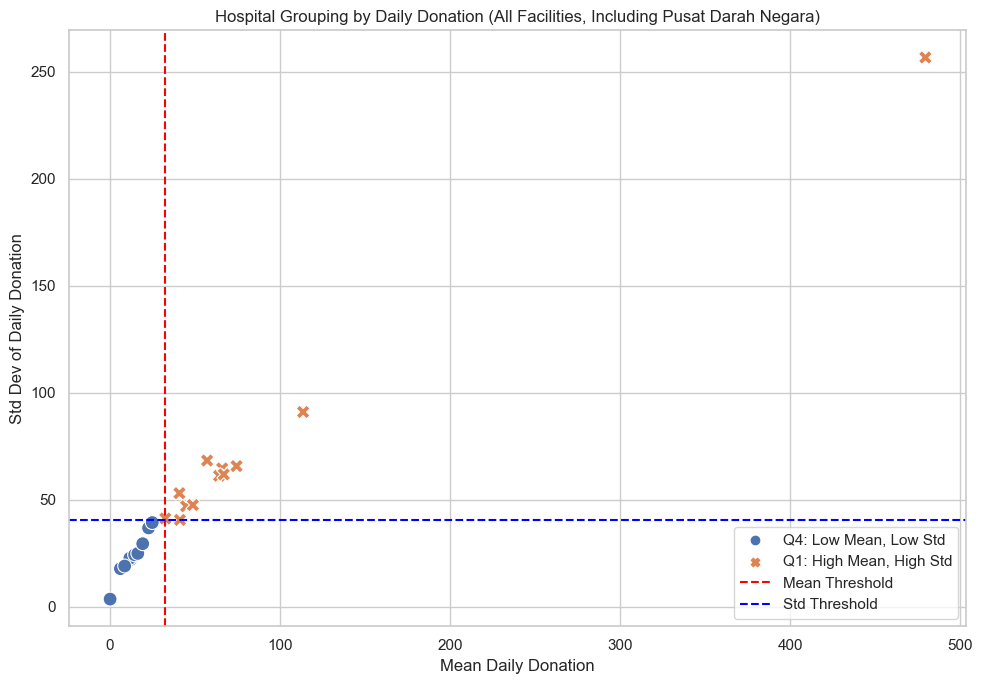


--- Hospitals in Q1: High Mean, High Std (All Facilities) --- (Total: 12 hospitals)


,Hospital,Mean Daily,Std Dev,Days
0,Pusat Darah Negara,479.363047,256.753568,7101
1,Hospital Sultanah Bahiyah,113.642163,90.975884,7101
2,Hospital Melaka,74.508942,65.672114,7101
3,Hospital Tengku Ampuan Rahimah,67.015632,61.775773,7101
4,Hospital Raja Permaisuri Bainun,66.069849,64.576926,7101
5,Hospital Sultanah Aminah,64.244050,61.145401,7101
6,Hospital Queen Elizabeth II,57.219687,68.270825,7101
7,Hospital Umum Sarawak,48.869455,47.462326,7101
8,Hospital Sultanah Nur Zahirah,44.873257,46.859232,7101
9,Hospital Tuanku Jaafar,41.248416,40.512449,7101



--- Hospitals in Q2: High Mean, Low Std (All Facilities) --- (Total: 0 hospitals)


,Hospital,Mean Daily,Std Dev,Days



--- Hospitals in Q3: Low Mean, High Std (All Facilities) --- (Total: 0 hospitals)


,Hospital,Mean Daily,Std Dev,Days



--- Hospitals in Q4: Low Mean, Low Std (All Facilities) --- (Total: 11 hospitals)


,Hospital,Mean Daily,Std Dev,Days
0,Hospital Sultanah Nora Ismail,24.985073,39.263922,7101
1,Hospital Seberang Jaya,22.821434,36.742847,7101
2,Hospital Tengku Ampuan Afzan,19.364878,29.377426,7101
3,Hospital Taiping,16.494015,24.834889,7101
4,Hospital Sultan Haji Ahmad Shah,14.615970,24.193334,7101
5,Hospital Miri,13.139839,22.942316,7101
6,Hospital Seri Manjung,12.293621,22.036854,7101
7,Hospital Sibu,11.815237,22.604193,7101
8,Hospital Tawau,8.769047,18.943984,7101
9,Hospital Duchess Of Kent,6.263484,17.699439,7101



Check for 'Pusat Darah Negara' in all facilities:


,mean,std,count,quadrant
hospital,,,,
Pusat Darah Negara,479.363047,256.753568,7101,"Q1: High Mean, High Std"


In [22]:
# Lower the minimum record threshold to include all facilities, even those with few records
hospital_stats_all = facility_df.groupby('hospital')['daily'].agg(['mean', 'std', 'count'])

# Calculate thresholds (median split) for all facilities
mean_thresh_all = hospital_stats_all['mean'].median()
std_thresh_all = hospital_stats_all['std'].median()

# Assign quadrants for all facilities
conditions_all = [
    (hospital_stats_all['mean'] >= mean_thresh_all) & (hospital_stats_all['std'] >= std_thresh_all),  # Q1
    (hospital_stats_all['mean'] >= mean_thresh_all) & (hospital_stats_all['std'] < std_thresh_all),   # Q2
    (hospital_stats_all['mean'] < mean_thresh_all) & (hospital_stats_all['std'] >= std_thresh_all),   # Q3
    (hospital_stats_all['mean'] < mean_thresh_all) & (hospital_stats_all['std'] < std_thresh_all)     # Q4
]
choices = ['Q1: High Mean, High Std', 'Q2: High Mean, Low Std', 'Q3: Low Mean, High Std', 'Q4: Low Mean, Low Std']
hospital_stats_all['quadrant'] = np.select(conditions_all, choices)

# Plot for all facilities
plt.figure(figsize=(10,7))
sns.scatterplot(data=hospital_stats_all, x='mean', y='std', hue='quadrant', style='quadrant', s=100)
plt.axvline(mean_thresh_all, color='red', linestyle='--', label='Mean Threshold')
plt.axhline(std_thresh_all, color='blue', linestyle='--', label='Std Threshold')
plt.title('Hospital Grouping by Daily Donation (All Facilities, Including Pusat Darah Negara)')
plt.xlabel('Mean Daily Donation')
plt.ylabel('Std Dev of Daily Donation')
plt.legend()
plt.tight_layout()
plt.show()

# Display all hospitals in each quadrant (all facilities) as tables
for q in choices:
    hospitals_in_q = hospital_stats_all[hospital_stats_all['quadrant'] == q].copy()
    display_df = hospitals_in_q[['mean', 'std', 'count']].sort_values(by='mean', ascending=False)
    display_df = display_df.reset_index().rename(columns={'hospital': 'Hospital', 'mean': 'Mean Daily', 'std': 'Std Dev', 'count': 'Days'})
    print(f"\n--- Hospitals in {q} (All Facilities) --- (Total: {len(display_df)} hospitals)")
    display(display_df)

# Check if 'Pusat Darah Negara' is present
print("\nCheck for 'Pusat Darah Negara' in all facilities:")
display(hospital_stats_all.loc[hospital_stats_all.index.str.contains('pusat darah negara', case=False)])

## 18. State Grouping by Daily Donation: Quadrant Analysis
We now perform the same quadrant analysis for states, grouping them by their average and variability of daily donations.

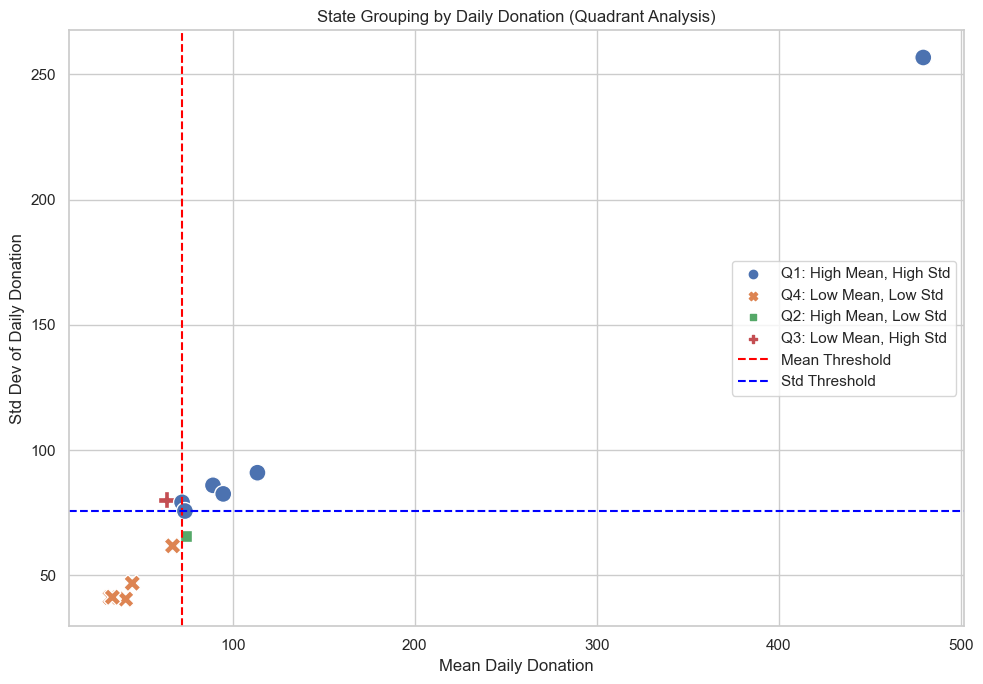


--- States in Q1: High Mean, High Std --- (Total: 6 states)


,State,Mean Daily,Std Dev,Days,Quadrant
0,W.P. Kuala Lumpur,479.363047,256.753568,7101,"Q1: High Mean, High Std"
1,Kedah,113.642163,90.975884,7101,"Q1: High Mean, High Std"
2,Perak,94.857485,82.511594,7101,"Q1: High Mean, High Std"
3,Johor,89.229123,85.934804,7101,"Q1: High Mean, High Std"
4,Sarawak,73.824532,75.676488,7101,"Q1: High Mean, High Std"
5,Sabah,72.252218,79.153676,7101,"Q1: High Mean, High Std"



--- States in Q2: High Mean, Low Std --- (Total: 1 states)


,State,Mean Daily,Std Dev,Days,Quadrant
0,Melaka,74.508942,65.672114,7101,"Q2: High Mean, Low Std"



--- States in Q3: Low Mean, High Std --- (Total: 1 states)


,State,Mean Daily,Std Dev,Days,Quadrant
0,Pulau Pinang,63.775243,80.183332,7101,"Q3: Low Mean, High Std"



--- States in Q4: Low Mean, Low Std --- (Total: 5 states)


,State,Mean Daily,Std Dev,Days,Quadrant
0,Selangor,67.015632,61.775773,7101,"Q4: Low Mean, Low Std"
1,Terengganu,44.873257,46.859232,7101,"Q4: Low Mean, Low Std"
2,Negeri Sembilan,41.248416,40.512449,7101,"Q4: Low Mean, Low Std"
3,Pahang,33.980848,41.272290,7101,"Q4: Low Mean, Low Std"
4,Kelantan,32.658921,41.169673,7101,"Q4: Low Mean, Low Std"


In [23]:
# State-level quadrant analysis
state_stats = state_df.groupby('state')['daily'].agg(['mean', 'std', 'count'])

# Include all states regardless of record count
mean_thresh_state = state_stats['mean'].median()
std_thresh_state = state_stats['std'].median()

conditions_state = [
    (state_stats['mean'] >= mean_thresh_state) & (state_stats['std'] >= std_thresh_state),  # Q1
    (state_stats['mean'] >= mean_thresh_state) & (state_stats['std'] < std_thresh_state),   # Q2
    (state_stats['mean'] < mean_thresh_state) & (state_stats['std'] >= std_thresh_state),   # Q3
    (state_stats['mean'] < mean_thresh_state) & (state_stats['std'] < std_thresh_state)     # Q4
]
choices_state = ['Q1: High Mean, High Std', 'Q2: High Mean, Low Std', 'Q3: Low Mean, High Std', 'Q4: Low Mean, Low Std']
state_stats['quadrant'] = np.select(conditions_state, choices_state)

# Plot for states
plt.figure(figsize=(10,7))
sns.scatterplot(data=state_stats, x='mean', y='std', hue='quadrant', style='quadrant', s=150)
plt.axvline(mean_thresh_state, color='red', linestyle='--', label='Mean Threshold')
plt.axhline(std_thresh_state, color='blue', linestyle='--', label='Std Threshold')
plt.title('State Grouping by Daily Donation (Quadrant Analysis)')
plt.xlabel('Mean Daily Donation')
plt.ylabel('Std Dev of Daily Donation')
plt.legend()
plt.tight_layout()
plt.show()

# Display all states in each quadrant as tables
for q in choices_state:
    states_in_q = state_stats[state_stats['quadrant'] == q].copy()
    display_df = states_in_q[['mean', 'std', 'count', 'quadrant']].sort_values(by='mean', ascending=False)
    display_df = display_df.reset_index().rename(columns={'state': 'State', 'mean': 'Mean Daily', 'std': 'Std Dev', 'count': 'Days', 'quadrant': 'Quadrant'})
    print(f"\n--- States in {q} --- (Total: {len(display_df)} states)")
    display(display_df)

**Interpretation for States:**
- Q1: Large, unstable states. Monitor and stabilize.
- Q2: Large, stable states. Can support others.
- Q3: Small, unstable states. Need support and stabilization.
- Q4: Small, stable states. Predictable, may need gradual support.

Use this to identify which states need the most blood donation and which can help others.